In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
low = [-1.0, -5.0]
high = [1.0, 5.0]
# Test with some sample values
samples = [(-1.2 , -5.1 ),
           (-0.75,  3.25),
           (-0.5 ,  0.0 ),
           ( 0.25, -1.9 ),
           ( 0.15, -1.75),
           ( 0.75,  2.5 ),
           ( 0.7 , -3.7 ),
           ( 1.0 ,  5.0 )]


In [5]:
from dtree import DNode

In [6]:
class QTree:
    """Composite Q-table with an internal tile coding scheme."""
    
    def __init__(self, lower, upper, split, action_size):
        """Create regular tile, implemented with tree structure
        Parameters
        ----------
        lower: array-like
            Lower bounds of grid for each dimension
        upper: array-like
            Upper bounds of grid for each dimension
        split: int
            number of cells for each dimension
            TODO: same value for every dimension
        action_size: int
            number of admissible actions
        """
        self.action_size = action_size
        self.state_sizes = len(lower)
        self.qtree = self.regular_qtree(lower, upper, split, action_size)

    def regular_qtree(self, lower, upper, split, action_size):
        MAXHEIGHT = int(np.log2(split) - 1)
        ACTIONSIZE = action_size

        init_lower = np.array(lower)
        init_upper = np.array(upper)
        init_dim = 0
        init_middle = (init_lower + init_upper) / 2
        init_idx = 0
        init_height = 0

        DIM = len(lower)
        assert len(lower) == len(upper) # state vector dimension should match

        root = DNode(init_middle[init_dim], init_dim)

        def reggrid_nd_q(idx, lower, upper, cur_height, n_dim):
            middle = (lower + upper)/2

            if cur_height > MAXHEIGHT:
                if n_dim == DIM - 1:
                    root[idx] = DNode(idx)
                    root[idx].q = np.zeros(ACTIONSIZE)
                    return
                else:
                    cur_height = 0
                    n_dim += 1
                    lower = init_lower
                    upper = init_upper
                    middle = (lower + upper) / 2
                    root[idx] = DNode(middle[n_dim], n_dim)

            if idx > 0:
                root[idx] = DNode(middle[n_dim], n_dim)

            reggrid_nd_q(2*idx+1, lower, middle, cur_height + 1, n_dim)
            reggrid_nd_q(2*idx+2, middle, upper, cur_height + 1, n_dim)

        reggrid_nd_q(init_idx, init_lower, init_upper, init_height, init_dim)
        return root

    def search_spacial(self, root, test_array): 
        """binary search on decision tree"""
        # Base Cases: root is null or key is present at root 
        if root is None or root.dim is None: 
            # returns q-value array, and its index of the node in the tree
            return root.q, root.value

        # Key is greater than root's key 
        if test_array[root.dim] < root.value: 
            return self.search_spacial(root.left, test_array)
        else:
            # Key is smaller than root's key 
            return self.search_spacial(root.right, test_array)
        
    def get(self, state, action, return_index=True):
        """Get Q-value for given <state, action> pair.
        
        Parameters
        ----------
        state: array_like
            array representing the state in the original continuous space
        action: int
            Index or label of action
        return_index: bool
            returns index of the node if true
            
        Returns
        -------
        value: float
            Q-value of given <state, action> pair
        idx: int
            index of the node in which the <state, action> pair falls
        """
    
        # TODO: parse state tree to get q-value array
        qarray, idx = self.search_spacial(self.qtree, state)
        # TODO: get q-value by accessing array
        q_value = qarray[action]
        if return_index:
            return q_value, idx
        else:
            return q_value
    
    
    def update(self, state, action, value, alpha=0.1):
        """Soft-update Q-value for given <state, action> pair to value.
        
        Instead of overwriting Q(state, action) with value, perform soft-update:
            Q(state, action) = alpha * value + (1.0 - alpha) * Q(state, action)
        
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        action : int
            Index of desired action.
        value : float
            Desired Q-value for <state, action> pair.
        alpha : float
            Update factor to perform soft-update, in [0.0, 1.0] range.
        """
        # get current value and its reference
        q_value_current, idx = self.get(state, action)
        # update the value based on observed value
        self.qtree[idx].q[action] = alpha * value + (1.0 - alpha) * q_value_current

# Test with a sample Q-table
tq = QTree(low, high, 4, 2)
s1 = 3; s2 = 4; a = 0; q = 1.0
print("[GET]    Q({}, {}) = {}".format(samples[s1], a, tq.get(samples[s1], a)))  # check value at sample = s1, action = a
print("[UPDATE] Q({}, {}) = {}".format(samples[s2], a, q)); tq.update(samples[s2], a, q)  # update value for sample with some common tile(s)
print("[GET]    Q({}, {}) = {}".format(samples[s1], a, tq.get(samples[s1], a)))  # check value again, should be slightly updated

[GET]    Q((0.25, -1.9), 0) = (0.0, 24)
[UPDATE] Q((0.15, -1.75), 0) = 1.0
[GET]    Q((0.25, -1.9), 0) = (0.1, 24)


In [7]:
print("[GET]    Q({}, {}) = {}".format(samples[s2], a, tq.get(samples[s2], a)))  # check value again, should be slightly updated

[GET]    Q((0.15, -1.75), 0) = (0.1, 24)


In [10]:
class QLearningAgent:
    """Q-Learning agent that can act on a continuous state space by discretizing it."""

    def __init__(self, env, tq, alpha=0.02, gamma=0.99,
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01, seed=0):
        """Initialize variables, create grid for discretization."""
        # Environment info
        self.env = env
        self.tq = tq 
        self.state_sizes = tq.state_sizes           # list of state sizes for each tiling
        self.action_size = self.env.action_space.n  # 1-dimensional discrete action space
        self.seed = np.random.seed(seed)
        print("Environment:", self.env)
        print("State space sizes:", self.state_sizes)
        print("Action space size:", self.action_size)
        
        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate   # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon

    def reset_episode(self, state):
        """Reset variables for a new episode."""
        # Gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)
        
        self.last_state = state
        Q_s = [self.tq.get(state, action, return_index=False) for action in range(self.action_size)]
        self.last_action = np.argmax(Q_s)
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon

    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        Q_s = [self.tq.get(state, action, return_index=False) for action in range(self.action_size)]
        # Pick the best action from Q table
        greedy_action = np.argmax(Q_s)
        if mode == 'test':
            # Test mode: Simply produce an action
            action = greedy_action
        else:
            # Train mode (default): Update Q table, pick next action
            # Note: We update the Q table entry for the *last* (state, action) pair with current state, reward
            value = reward + self.gamma * max(Q_s)
            self.tq.update(self.last_state, self.last_action, value, self.alpha)
            
#            self.tq.update_subtile_weight(self.last_state, self.last_action, value, self.slpha)
#            self.tq.split_tile()
            
            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the greedy action
                action = greedy_action

        # Roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action



In [11]:
import gym
# Create an environment
env = gym.make('Acrobot-v1')
env.seed(505);

# Explore state (observation) space
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

# Explore action space
print("Action space:", env.action_space)

State space: Box(6,)
- low: [ -1.        -1.        -1.        -1.       -12.566371 -28.274334]
- high: [ 1.        1.        1.        1.       12.566371 28.274334]
Action space: Discrete(3)


In [12]:
n_bins = 2
#bins = tuple([n_bins]*env.observation_space.shape[0])
#tiling_specs = [(bins, tuple([0.0]*env.observation_space.shape[0]))
#               ]

# tq = TiledQTable(env.observation_space.low, 
#                  env.observation_space.high, 
#                  tiling_specs, 
#                  env.action_space.n)
tq = QTree(env.observation_space.low, env.observation_space.high, n_bins, env.action_space.n)
agent = QLearningAgent(env, tq)

Environment: <TimeLimit<AcrobotEnv<Acrobot-v1>>>
State space sizes: 6
Action space size: 3


In [14]:
%%time
def run(agent, env, num_episodes=10000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes+1):
        # Initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False

        # Roll out steps until done
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.act(state, reward, done, mode)

        # Save final score
        scores.append(total_reward)

        # Print episode stats
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score
            if i_episode % 100 == 0:
                print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                sys.stdout.flush()
    return scores

scores = run(agent, env)

Episode 10000/10000 | Max Average Score: -103.3CPU times: user 6min 33s, sys: 7.72 s, total: 6min 41s
Wall time: 6min 27s


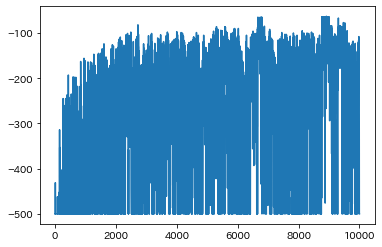

In [16]:
import matplotlib.pyplot as plt
plt.plot(range(len(scores)), scores)